# SPIRE / BLAST-TNG Diff Analyis

Manipulate BLAST-TNG image to fit to Herschel/SPIRE photometer maps.

## 1. Load Maps

In [98]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import scipy.ndimage as ndimage
import scipy.optimize as opt

spire_file = os.path.join(os.getcwd(), 'maps', 'spire_hiresPLW.npy')
blasttng_file = os.path.join(os.getcwd(), 'maps', 'blasttng_it2.npy')
spire_map = np.load(spire_file)
blasttng_map = np.load(blasttng_file)

## 2. Show Side-By-Side

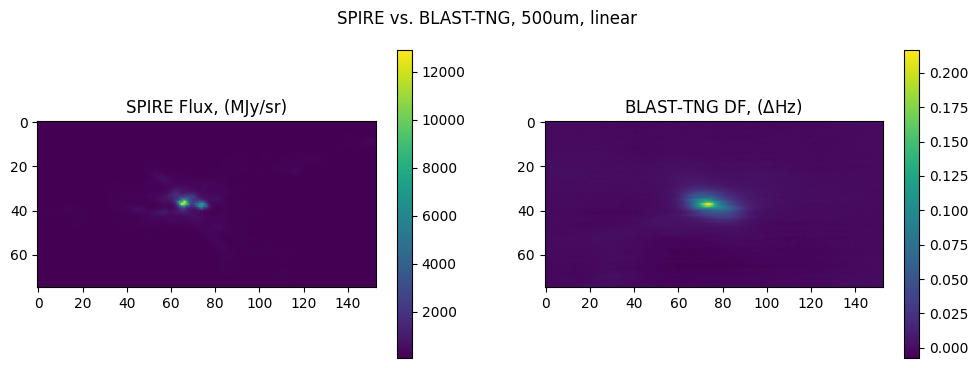

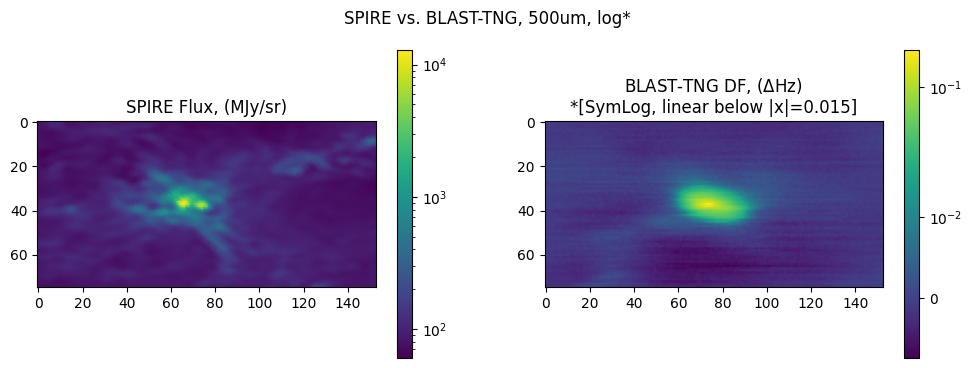

In [99]:

def plot_side_by_side(img1, img2,
                      parent_title=None,
                      title1=None, title2=None,
                      norm1=None, norm2=None,
                      offset1=0, offset2=0):
    parent, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(12, 4))
    parent.suptitle(parent_title)
    fig1 = ax1.imshow(img1 + offset1, norm=norm1)
    ax1.set_title(title1)
    plt.colorbar(fig1, ax=ax1)
    fig2 = ax2.imshow(img2 + offset2, norm=norm2)
    ax2.set_title(title2)
    plt.colorbar(fig2, ax=ax2)
    plt.show()

plot_side_by_side(spire_map, blasttng_map,
                  title1='SPIRE Flux, (MJy/sr)', title2=r'BLAST-TNG DF, ($\Delta$Hz)',
                  parent_title='SPIRE vs. BLAST-TNG, 500um, linear')

symlog_linthresh = 0.015
plot_side_by_side(spire_map, blasttng_map,
                  title1='SPIRE Flux, (MJy/sr)',
                  title2=r'BLAST-TNG DF, ($\Delta$Hz)'f'\n*[SymLog, linear below |x|={symlog_linthresh}]',
                  parent_title='SPIRE vs. BLAST-TNG, 500um, log*',
                  norm1=colors.LogNorm(), norm2=colors.SymLogNorm(symlog_linthresh))

## 3. Determine Optimal Gaussian Blur

We see that the BLAST-TNG image is subject to significant "blurring". In order to produce an interpretable difference map, we aim to apply a gaussian blur to the SPIRE image to mimic the effect of the beam Point Spread Function and pointing solution error.

Optimization terminated successfully.
         Current function value: 0.021770
         Iterations: 53
         Function evaluations: 96


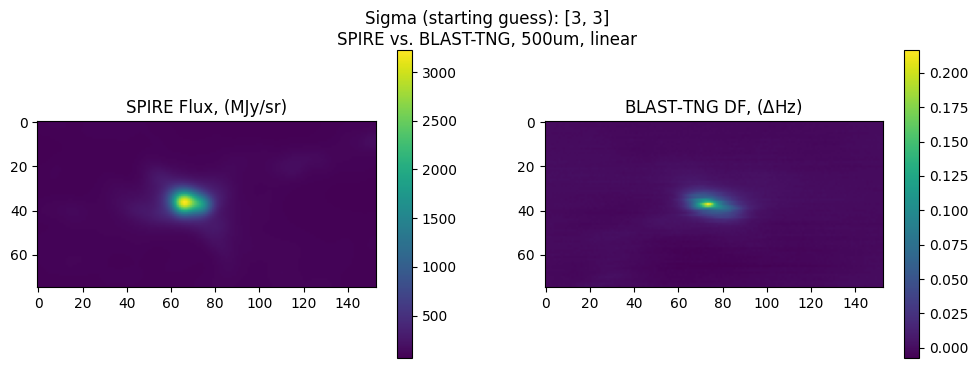

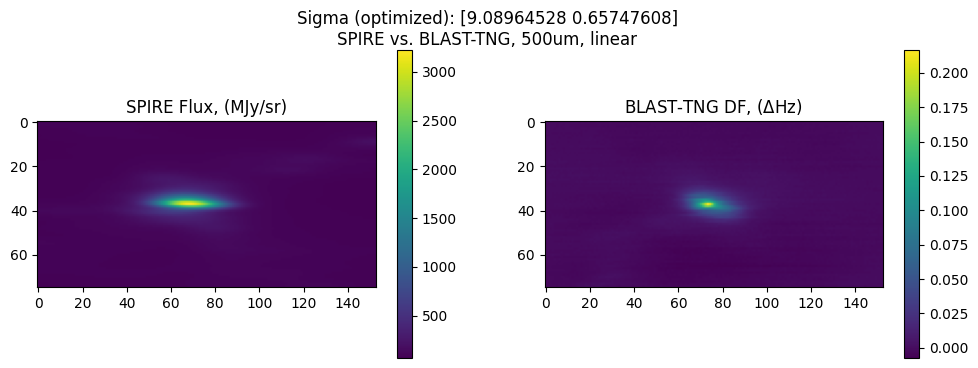

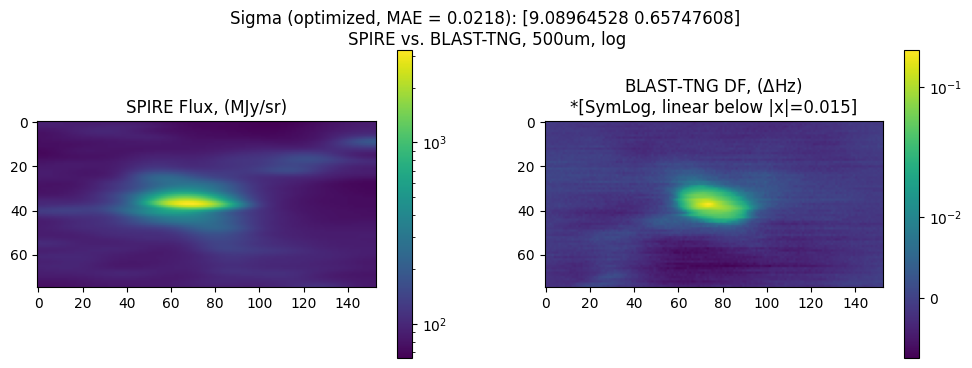

In [100]:
def normalize_img(img) -> np.ndarray:
    """Normalize img. between 0-1. Ignores NaN values.

    :param img: 
    :return: 
    """
    min = np.nanmin(img)
    max = np.nanmax(img)
    return (img - min) / (max - min)

def normalized_mae(img1, img2) -> float:
    """Determine the Mean Absolute Error (MAE) between two images.
    Normalizes each image between 0-1 before computing error.
    Ignores NaN values.

    :param ndarray img1: image 1
    :param ndarray img2: image 2
    """
    norm1 = normalize_img(img1)
    norm2 = normalize_img(img2)
    diff = np.abs(norm1 - norm2)
    return np.nanmean(diff)

# minimize this to determine optimal sigma_x and sigma_y
# assumption: PSF (using this term to represent overall error spread, not just optical) is a gaussian, scaled in x and y.
def blurred_error(sigma, verbose=False) -> float:
    # invert array by slicing [::-1] because numpy operates on (rows, cols) instead of (x, y)
    blurred_spire = ndimage.gaussian_filter(spire_map, sigma=sigma[::-1])
    err = normalized_mae(blurred_spire, blasttng_map)
    if verbose: print(f"Error: {err:.5f}, {sigma=}")
    return err

initial_guess = [3, 3]  # sigma_x, sigma_y

optimized_sigma = opt.fmin(blurred_error, initial_guess)
blur_mae = blurred_error(optimized_sigma)

plot_side_by_side(ndimage.gaussian_filter(spire_map, sigma=initial_guess[::-1]), blasttng_map,
                  title1='SPIRE Flux, (MJy/sr)', title2=r'BLAST-TNG DF, ($\Delta$Hz)',
                  parent_title=f'Sigma (starting guess): {initial_guess}\nSPIRE vs. BLAST-TNG, 500um, linear')
plot_side_by_side(ndimage.gaussian_filter(spire_map, sigma=optimized_sigma[::-1]), blasttng_map,
                  title1='SPIRE Flux, (MJy/sr)', title2=r'BLAST-TNG DF, ($\Delta$Hz)',
                  parent_title=f'Sigma (optimized): {optimized_sigma}\nSPIRE vs. BLAST-TNG, 500um, linear')
plot_side_by_side(ndimage.gaussian_filter(spire_map, sigma=optimized_sigma[::-1]), blasttng_map,
                  title1='SPIRE Flux, (MJy/sr)',
                  title2=r'BLAST-TNG DF, ($\Delta$Hz)'f'\n*[SymLog, linear below |x|={symlog_linthresh}]',
                  parent_title=f'Sigma (optimized, MAE = {blur_mae:.4f}): {optimized_sigma} \nSPIRE vs. BLAST-TNG, 500um, log',
                  norm1=colors.LogNorm(), norm2=colors.SymLogNorm(symlog_linthresh))

### 3.1 Compute Blur $\sigma$ vs. MAE

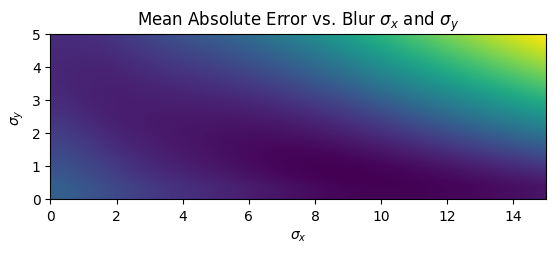

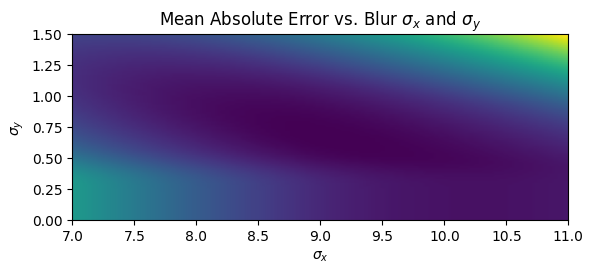

In [101]:
def plot_sigma_vs_mae(window):
    x_vals = np.linspace(window[0], window[1], 100)
    y_vals = np.linspace(window[2], window[3], 100)

    X, Y = np.meshgrid(x_vals, y_vals)
    coords = np.stack((X, Y), axis=-1)

    result = np.empty(X.shape)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            result[i, j] = blurred_error(coords[i, j])

    plt.imshow(result, extent=window, origin='lower', norm=colors.LogNorm())
    plt.title(r'Mean Absolute Error vs. Blur $\sigma_x$ and $\sigma_y$')
    plt.xlabel(r'$\sigma_x$')
    plt.ylabel(r'$\sigma_y$')
    plt.show()

wide_window = (0, 15, 0, 5)  # (x_min, x_max, y_min, y_max)
zoomed_window = (7, 11, 0, 1.5)
plot_sigma_vs_mae(wide_window)
plot_sigma_vs_mae(zoomed_window)

# fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
# ax.plot_surface(X, Y, result, cmap='viridis')
# plt.show()

## 4. Compute & Show Diff

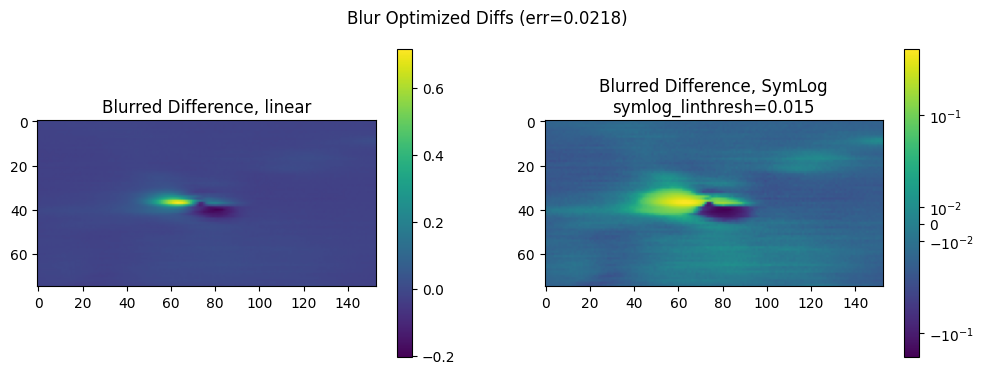

In [102]:
diff = normalize_img(ndimage.gaussian_filter(spire_map, sigma=optimized_sigma[::-1])) - normalize_img(blasttng_map)

plot_side_by_side(diff, diff,
                  title1='Blurred Difference, linear',
                  title2='Blurred Difference, SymLog'
                         f'\n{symlog_linthresh=}',
                  norm2=colors.SymLogNorm(0.05),
                  parent_title=f'Blur Optimized Diffs (err={blur_mae:.4f})')

## 4. Optimize Pixel Offsets

Due to systematic errors (in pointing solution or in map-making process), we may expect a slight offset between our images.
It is known that RCW 92 is a dual source, yet maps from KIDs were simply aligned using their maximum brightness pixel. This would introduce an error if the position of RCW 92 as located by Astropy does not exactly align with the brightest point of RCW 92.

Thus, we introduce two new parameters in our optimization, `x_offset` & `y_offset`.


Optimization terminated successfully.
         Current function value: 0.019000
         Iterations: 330
         Function evaluations: 548


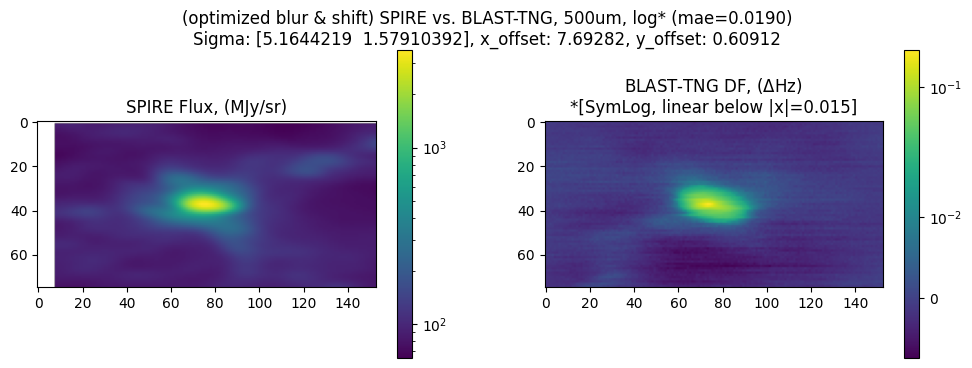

In [103]:
def blur_and_offset(img, xform_params) -> np.ndarray:
    """Blur and apply a pixel offset to an image. Leaves NaN values for newly undefined pixels.

    :param ndarray img: image to modify
    :param ndarray xform_params: [sigma_x, sigma_y, offset_x, offset_y]
    :return ndarray img: blurred and shifted image
    """
    sigma_row = xform_params[1]
    sigma_col = xform_params[0]
    offset_row = xform_params[3]
    offset_col = xform_params[2]
    blurred = ndimage.gaussian_filter(img, sigma=(sigma_row, sigma_col))
    return ndimage.shift(blurred, (offset_row, offset_col), cval=np.nan)

def blurred_shifted_error(xform_params, verbose=False) -> float:
    """
    :param ndarray xform_params: [sigma_x, sigma_y, offset_x, offset_y]
    :return: MAE of transformed image
    """
    xformed_spire = blur_and_offset(spire_map, xform_params)
    err = normalized_mae(xformed_spire, blasttng_map)
    if verbose: print(f"Error: {err:.5f}, {xform_params=}")
    return err

initial_guess = [optimized_sigma[0], optimized_sigma[1], -10, -10]

optimized_params = opt.fmin(blurred_shifted_error, initial_guess)
blur_shift_mae = blurred_shifted_error(optimized_params)

plot_side_by_side(blur_and_offset(spire_map, optimized_params), blasttng_map,
                  title1='SPIRE Flux, (MJy/sr)',
                  title2=r'BLAST-TNG DF, ($\Delta$Hz)'f'\n*[SymLog, linear below |x|={symlog_linthresh}]',
                  parent_title=f'(optimized blur & shift) SPIRE vs. BLAST-TNG, 500um, log* (mae={blur_shift_mae:.4f})'
                               f'\nSigma: {optimized_params[:2]}'
                               f', x_offset: {optimized_params[2]:.5f}, y_offset: {optimized_params[3]:.5f}',
                  norm1=colors.LogNorm(), norm2=colors.SymLogNorm(symlog_linthresh))

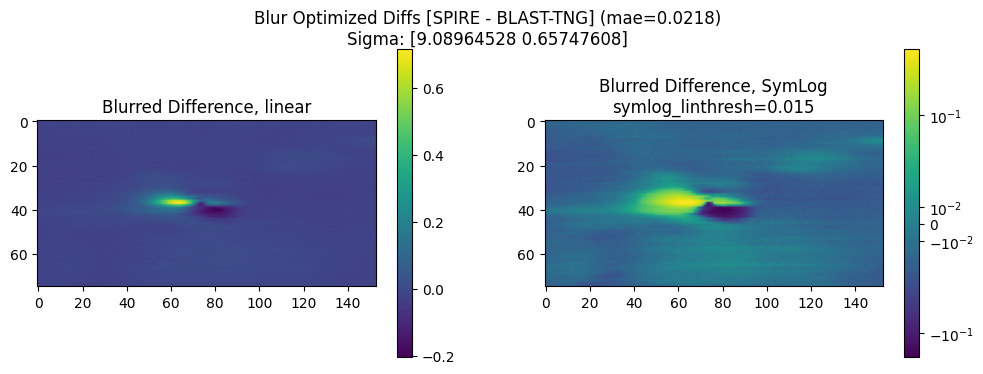

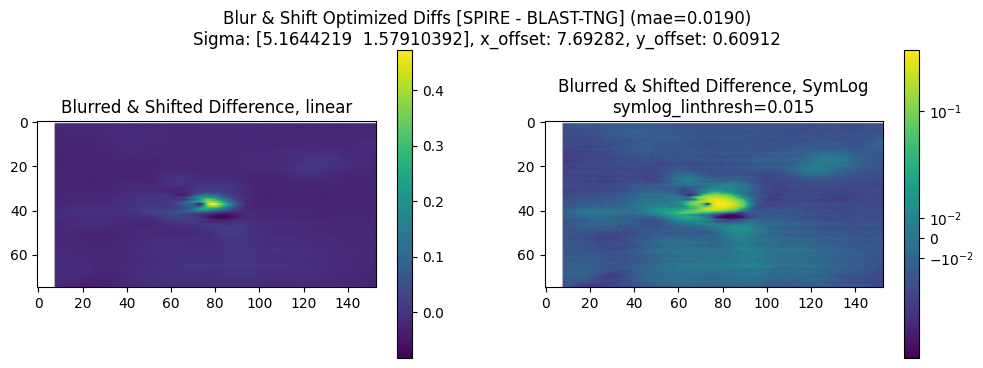

In [104]:
blur_diff = normalize_img(ndimage.gaussian_filter(spire_map, sigma=optimized_sigma[::-1])) - normalize_img(blasttng_map)
blur_shift_diff = normalize_img(blur_and_offset(spire_map, optimized_params)) - normalize_img(blasttng_map)

plot_side_by_side(blur_diff, blur_diff,
                  title1='Blurred Difference, linear',
                  title2='Blurred Difference, SymLog'
                         f'\n{symlog_linthresh=}',
                  norm2=colors.SymLogNorm(0.05),
                  parent_title=f'Blur Optimized Diffs [SPIRE - BLAST-TNG] (mae={blur_mae:.4f})'
                        f'\nSigma: {optimized_sigma}')

plot_side_by_side(blur_shift_diff, blur_shift_diff,
                  title1='Blurred & Shifted Difference, linear',
                  title2='Blurred & Shifted Difference, SymLog'
                         f'\n{symlog_linthresh=}',
                  norm2=colors.SymLogNorm(0.05),
                  parent_title=f'Blur & Shift Optimized Diffs [SPIRE - BLAST-TNG] (mae={blur_shift_mae:.4f})'
                        f'\nSigma: {optimized_params[:2]}'
                        f', x_offset: {optimized_params[2]:.5f}, y_offset: {optimized_params[3]:.5f}')

We see from the above plots that the optimization found that almost zero shift was optimal to improve the image. This is a good sign since it indicates that the images are correctly aligned in the x-y axes.

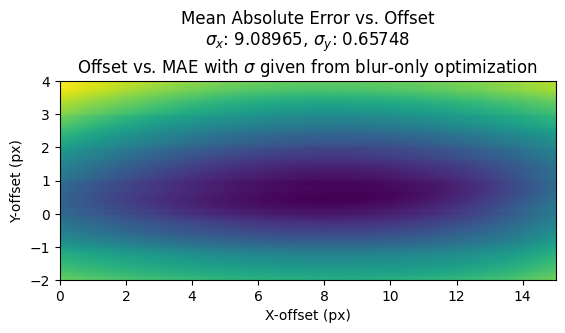

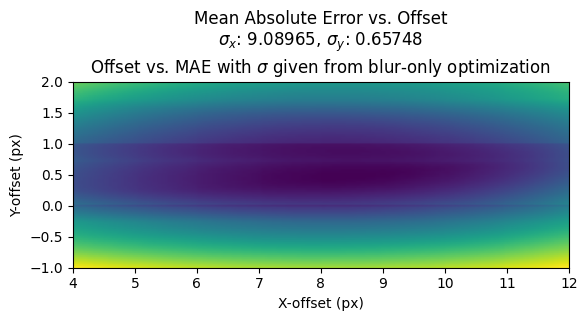

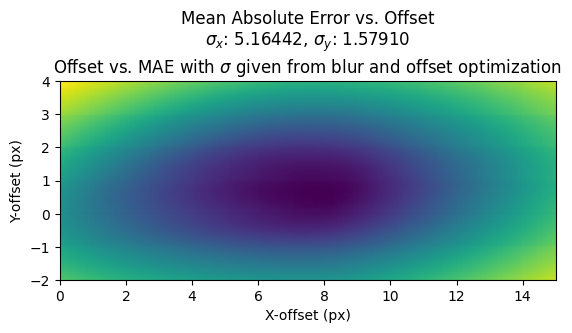

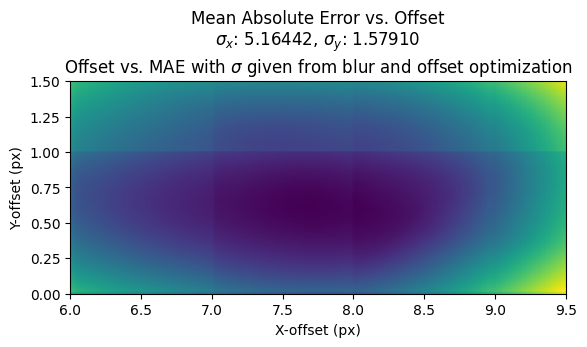

In [105]:
def plot_offset_vs_mae(window, sigma, append_title=''):
    x_vals = np.linspace(window[0], window[1], 100)
    y_vals = np.linspace(window[2], window[3], 100)

    X, Y = np.meshgrid(x_vals, y_vals)
    coords = np.stack((X, Y), axis=-1)

    result = np.empty(X.shape)
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            result[i, j] = blurred_shifted_error((*sigma, *coords[i, j]))

    plt.imshow(result, extent=window, origin='lower', norm=colors.LogNorm())
    plt.title('Mean Absolute Error vs. Offset\n'
              rf'$\sigma_x$: {sigma[0]:.5f}, $\sigma_y$: {sigma[1]:.5f}'
              + append_title)
    plt.xlabel('X-offset (px)')
    plt.ylabel('Y-offset (px)')
    plt.show()

wide_window = (0, 15, -2, 4)  # (x_min, x_max, y_min, y_max)

description = r'Offset vs. MAE with $\sigma$ given from blur-only optimization'
plot_offset_vs_mae(wide_window, optimized_sigma, append_title='\n'+description)
plot_offset_vs_mae((4, 12, -1, 2), optimized_sigma, append_title='\n'+description)

description = r'Offset vs. MAE with $\sigma$ given from blur and offset optimization'
plot_offset_vs_mae(wide_window, optimized_params[:2], append_title='\n'+description)
plot_offset_vs_mae((6, 9.5, 0, 1.5), optimized_params[:2], append_title='\n'+description)

# very_wide_window = (-50, 50, -50, 50)
# plot_offset_vs_mae(very_wide_window, optimized_sigma)
# plot_offset_vs_mae(very_wide_window, optimized_params[:2])